# **Quantile Boosting & Random Forests sur des séries temporelles.**

[Introduction](https://towardsdatascience.com/introduction-to-python-for-data-science-6d1dba7c305c) à Python.

*NB :* 
* *Le boosting est une méthode séquentielle tandis que les random forest est en parallèle (bagging).*
* *Les régressions quantiles permettent d'étudier des données peu importe leur répartition, et de ne pas être fortement influencé par les valeurs aberrantes.* 

## Librairies
*Elles fournissent des outils et fonctions avancées pour ce qu'on souhaite faire (ouvrir des fichiers avec des extensions particulières, faire de jolis graphiques, modéliser des données cérébrales, faire des cartes).*

In [ ]:
# Pour manipuler des matrices / tableaux (https://courspython.com/apprendre-numpy.html)
import numpy as np

# Pour visualiser graphiquement des données (https://openclassrooms.com/fr/courses/4452741-decouvrez-les-librairies-python-pour-la-data-science/4740942-maitrisez-les-possibilites-offertes-par-matplotlib)
import matplotlib.pyplot as plt 

# Pour manipuler et traiter des données numériques dont les séries temporelles (https://datascientest.com/pandas-python-data-science)
import pandas as pd  

# Pour visualiser graphiquement : complète matplotlib (https://openclassrooms.com/fr/courses/4452741-decouvrez-les-librairies-python-pour-la-data-science/5559011-realisez-de-beaux-graphiques-avec-seaborn)
import seaborn as sns 

# Pour évaluer les performances de classification : si l'algo fait bien son travail, et comment (https://scikit-learn.org/stable/modules/model_evaluation.html)
from sklearn import metrics

## Données

### Import et stockage

In [ ]:
# Pour lire les fichiers .csv (beaucoup de jeux de données classiques sont en .csv, format que l'on peut ouvrir avec Excel, par exemple)
from pandas import read_csv

# Pour faire un beau graphique 
from matplotlib import pyplot

# On récupère le jeu de données, en expliquant celui qu'on veut, s'il possède des entêtes (ici, aucune), la colonne qui sert d'index, c'est-à-dire de référence, du style un numéro unique, comme les clés en BDD... (ici, la première colonne, donc 0, sert d'index)
#series = read_csv('airline-passengers.csv', header = 0, index_col = 0)
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', header = 0, index_col = 0)

# On stock les valeurs de la série qu'on vient d'importer dans une variable "values"
values = series.values


### Visualisation

*On représente graphiquement ces fameuses valeurs pour voir ce que ça donne, ça permet d'orienter les traitements et analyses possibles*

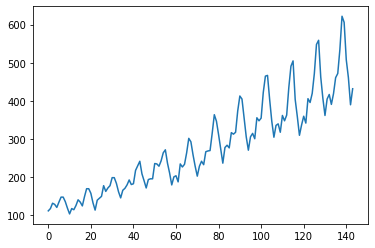

In [ ]:
# On lui dit ce qu'on prend à représenter (ici, values qu'on vient de créer)
pyplot.plot(values)

# On affiche ce graphique
pyplot.show()

## Prédiction des naissances mensuelles en Random Forest

### Librairies

In [ ]:
#Pour convertir les données d'un tableau (bien pratique quand elles sont pas toujours saisies comme on le voudrait): https://fr.acervolima.com/numpy-asarray-en-python/
from numpy import asarray

# Pour lire les fichiers .csv (beaucoup de jeux de données classiques sont en .csv, format que l'on peut ouvrir avec Excel, par exemple)
from pandas import read_csv

# Ce sont des tableaux bien pratiques, sur lesquels on peut effectuer un grand nombre de manipulations : http://www.python-simple.com/python-pandas/creation-dataframes.php
from pandas import DataFrame

# Permet de concatener des séries d'un DF, par exemple : https://fr.acervolima.com/fonction-pandas-concat-en-python/
from pandas import concat

# Pour réaliser une régression en Random Forest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html (sorry en anglais)
from sklearn.ensemble import RandomForestRegressor
 

### Données
*On transforme le jeu de données temporelles en un jeu de données pour apprentissage supervisé (on lui donne les réponses qu'il est sensé obtenir)*


#### Fonction
*On crée une fonction pour traiter les données*


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# Si on met en entrée une liste, n_vars prend 1, sinon ça prend la valeur 2ème valeur de data.shape (on indexe à partir de 0) qui donne le nombre de lignes [0] puis colonnes [1] : https://courspython.com/tableaux.html
	n_vars = 1 if type(data) is list else data.shape[1]
	# On stock les données dans un tableau qu'on nomme df (classique pour les dataframes) : 
	df = DataFrame(data)
	# On créer une liste vide qu'on nomme cols
	cols = list()
 
	# Séquence d'entrée (t-n, ... t-1) : boucle de celles qu'on connaît déjà, donc jusqu'à l'instant t exclu
	for i in range(n_in, 0, -1):
		# On ajoute à la liste l'index concerné, shift permet de décaler l'index du tableau : https://www.delftstack.com/fr/api/python-pandas/pandas-dataframe-dataframe.shift-function/
		cols.append(df.shift(i))
	
	# Séquence de prédiction (t, t+1, ... t+n) : boucle de celles qu'on prédit, donc à partir de l'instant t
	for i in range(0, n_out):
		# De même, mais en prenant l'opposé
		cols.append(df.shift(-i))
	
	# On les concatène avec la fonction vue plus haut
	agg = concat(cols, axis=1)
	
	# On retire les lignes vides (pratique quand on a des jeux de données incomplets notamment)
	if dropnan:
		agg.dropna(inplace=True)
	
	# On ressort les valeurs restantes
	return agg.values


#### Chargement et stockage

In [ ]:
# On charge les données (le fameux csv) en indiquant qu'on a pas d'entête et que l'index (référence) est la première colonne (la 0)
#series = read_csv('daily-max-temperatures.csv', header=0, index_col=0)
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv', header=0, index_col=0)

# On stocke les valeurs dans une variable data
data = series.values

### Prédiction

#### Préparation du jeu de données

In [ ]:
# On fixe le nombre de tests du modèle à 100
n_test = 100

# On divise le jeu de données en deux parties : celui qui sert à s'entraîner / apprendre, et celui qui sert à se tester selon le nombre de tests qu'on a défini (n_test)
# On crée la fonction
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# On applique la fonction à notre jeu de données
train, test = train_test_split(data,n_test) 

#### Apprentissage


In [ ]:
# On transforme le jeu de données temporelles en un jeu de données pour apprentissage supervisé
Train = series_to_supervised(train, n_in=6)

# On sépare en colonnes d'entrée et de sortie (question / réponse)
X_train, y_train = Train[:, :-1], Train[:, -1]

## Quantile Gradient Boosting

### Entraînement

In [ ]:
# On transforme le jeu de données temporelles en un jeu de données pour apprentissage supervisé
Test = series_to_supervised(test, n_in=6)

# On sépare en colonnes d'entrée et de sortie (question / réponse)
X_test, y_test = Test[:, :-1], Test[:, -1]

### Modèle

In [ ]:
# On crée le modèle de régression en Random Forest
model = RandomForestRegressor(n_estimators=1000)

# On le remplit avec les données d'entraînement : https://leandeep.com/commandes-python-de-base-pour-sklearn-régression-classification-régularisation/
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

### Prédiction

In [ ]:
# On crée une variable pour les nouvelles prédictions 
row = values[-6:].flatten()

# Prédiction en one-step
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [622 606 508 461 390 432], Predicted: 31.281


### Régression


#### Librairies & quantiles

In [ ]:
# Pour réaliser une régression en Gradient Boosting : https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html (sorry toujours celui en anglais)
from sklearn.ensemble import GradientBoostingRegressor

# On crée une variable avec les quantiles classiques 
quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

#### Fonction pour le Gradient Boosting

In [ ]:
# Faire le modèle et les prédictions en (a) - (b)
def GBM(q):
    
   # (a) Modèle  
   mod = GradientBoostingRegressor(loss='quantile', alpha=q,
                                n_estimators=500, max_depth=8,
                                learning_rate=.01, min_samples_leaf=20,
                                min_samples_split=20)
   # On le remplit
   mod.fit(X_train, y_train)

   # (b) Prédictions
   pred = pd.Series(mod.predict(X_test).round(2))
   
   # La fonction ressort les prédictions et le modèles créés
   return pred, mod

#### Modèle & prédiction

In [ ]:
# On crée une liste pour les modèles
GBM_models=[]
# On crée un dataframe pour les prédictions
GBM_actual_pred = pd.DataFrame()

# On remplit ces listes des modèles et prédictions pour chaque quantiles grâce à la fonction définie au-dessus
for q in quantiles:
    pred , model = GBM(q)
    GBM_models.append(model)
    GBM_actual_pred = pd.concat([GBM_actual_pred,pred],axis=1)

# On ajoute des colonnes au dataframe des prédictions
# On en crée une avec les quantiles
GBM_actual_pred.columns=quantiles

# On en crée une avec les données de tests
GBM_actual_pred['actual'] = y_test

# On en crée une en comparant les quantiles
GBM_actual_pred['interval'] = GBM_actual_pred[np.max(quantiles)] - GBM_actual_pred[np.min(quantiles)]

# On en crée une en organisant les valeurs de la colonne 'interval' selon leurs valeurs
GBM_actual_pred = GBM_actual_pred.sort_values('interval')

# On affiche le dataframe
GBM_actual_pred

,0.01,0.05,0.5,0.95,0.99,actual,interval
24,13.96,14.36,17.71,21.03,22.75,16.8,8.79
23,13.76,13.99,16.66,20.17,23.20,16.0,9.44
14,11.01,12.37,15.27,18.03,20.55,18.9,9.54
8,12.15,12.64,15.88,19.21,22.13,15.3,9.98
11,12.64,14.56,17.73,21.52,22.68,20.8,10.04
...,...,...,...,...,...,...,...
67,16.54,19.19,25.43,38.55,38.77,36.9,22.23
91,15.85,17.97,22.00,33.89,38.38,25.1,22.53
39,16.84,18.89,25.45,35.93,39.88,32.6,23.04
90,16.82,18.97,28.91,38.22,40.08,23.2,23.26


#### Visualisation

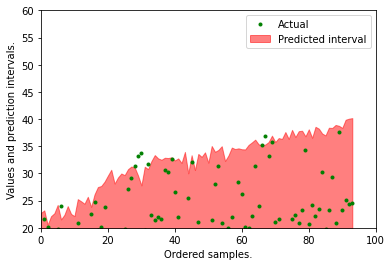

In [ ]:
# On prépare, légende, échelonne et affiche le graphique
plt.plot(GBM_actual_pred['actual'],'go',markersize=3,label='Actual')

plt.fill_between(
    np.arange(GBM_actual_pred.shape[0]), GBM_actual_pred[0.01], GBM_actual_pred[0.99], alpha=0.5, color="r",
    label="Predicted interval")

# Nom des axes
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")

# Graduation des axes
plt.xlim([0, 100])
plt.ylim([20, 60])

# Légende
plt.legend()

# Affichage
plt.show()

#### Perfomance

In [ ]:
# On calcule le R2 du modèle (à quel point le modèle explique la variance)
r2 = metrics.r2_score(GBM_actual_pred['actual'], GBM_actual_pred[0.5]).round(2)

# On l'affiche
print('R2 score is {}'.format(r2))

R2 score is 0.15


#### Prédictions correctes

In [ ]:
# On crée une fonction pour compter le taux de prédictions correctes
def correctPcnt(actual_pred):
    correct = 0
    for i in range(actual_pred.shape[0]):
        if actual_pred.loc[i,0.01] <= actual_pred.loc[i,'actual'] <= actual_pred.loc[i,0.99]:
            correct += 1
    print(correct/len(y_test))
    
# On l'applique à notre fameux dataframe qui nous sort le taux de prédictions correctes  
correctPcnt(GBM_actual_pred)

0.9574468085106383


## Quantile Random Forests

### Régression


#### Librairies & quantiles

In [ ]:
# Pour réaliser une régression en Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=0,min_samples_split=10)

# On remplit le modèle
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=0)

#### Modèle & prédictions

In [ ]:
# On récupère les prédictions de tous les arbres pour toutes les observations dans un dataframe
pred_Q = pd.DataFrame()

for pred in rf.estimators_:
    temp = pd.Series(pred.predict(X_test).round(2))
    pred_Q = pd.concat([pred_Q,temp],axis=1)

# Chaque observation possède N prédictions des N arbres
# On affiche les premières valeurs
pred_Q.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,16.01,17.73,15.50,19.12,15.99,16.63,16.37,15.50,18.92,19.72,...,22.10,19.52,17.99,18.31,18.03,18.40,18.37,18.72,18.86,18.35
1,15.91,17.73,19.87,17.05,19.46,15.38,16.10,18.72,17.88,15.30,...,15.42,14.50,18.42,18.31,16.73,20.92,14.68,18.72,18.50,16.29
2,19.23,16.15,21.32,24.06,21.57,20.25,24.22,18.66,19.32,25.24,...,18.66,16.77,24.94,16.90,24.10,24.30,19.24,24.01,32.80,16.40
3,15.12,21.14,17.44,22.41,18.76,24.09,17.19,26.19,18.97,27.32,...,19.46,16.77,19.51,24.25,17.33,15.62,19.29,22.23,20.69,24.28
4,14.44,17.29,16.96,16.55,16.32,13.63,16.40,15.94,18.45,17.19,...,15.30,14.54,16.70,16.09,16.25,16.36,16.53,17.44,12.15,16.64


In [ ]:
# On crée un dataframe des prédictions (comme on a fait en GBM)
RF_actual_pred = pd.DataFrame()

# On remplit ces listes des modèles et prédictions pour chaque quantiles grâce à la fonction définie au-dessus
for q in quantiles:
    s = pred_Q.quantile(q=q, axis=1)
    RF_actual_pred = pd.concat([RF_actual_pred,s],axis=1,sort=False)
   
# On ajoute des colonnes au dataframe des prédictions
# On en crée une avec les quantiles
RF_actual_pred.columns=quantiles

# On en crée une avec les données de tests
RF_actual_pred['actual'] = y_test

# On en crée une en comparant les quantiles
RF_actual_pred['interval'] = RF_actual_pred[np.max(quantiles)] - RF_actual_pred[np.min(quantiles)]

# On en crée une en organisant les valeurs de la colonne 'interval' selon leurs valeurs
RF_actual_pred = RF_actual_pred.sort_values('interval')

# On arrondit les valeurs
RF_actual_pred = RF_actual_pred.round(2)

# On affiche le dataframe
RF_actual_pred

,0.01,0.05,0.5,0.95,0.99,actual,interval
21,13.40,13.87,15.83,19.05,20.50,17.1,7.10
43,14.59,15.47,18.69,20.77,21.96,17.2,7.37
4,10.60,12.90,16.55,18.33,18.90,14.8,8.30
13,10.20,12.16,13.80,16.70,18.60,14.3,8.40
50,13.47,14.49,17.24,20.83,21.90,18.5,8.43
...,...,...,...,...,...,...,...
91,17.97,18.58,25.08,38.70,39.00,25.1,21.03
90,19.23,20.87,29.35,39.18,40.58,23.2,21.35
93,16.50,18.18,23.46,32.16,38.01,24.6,21.51
39,18.82,19.66,25.14,39.12,40.87,32.6,22.05


#### Visualisation

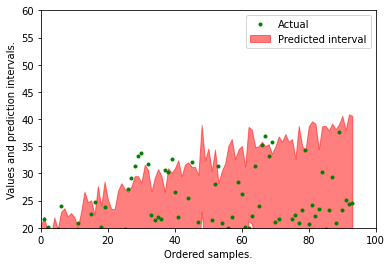

In [ ]:
# On prépare, légende, échelonne et affiche le graphique
plt.plot(RF_actual_pred['actual'],'go',markersize=3,label='Actual')

plt.fill_between(
    np.arange(RF_actual_pred.shape[0]), RF_actual_pred[0.01], RF_actual_pred[0.99], alpha=0.5, color="r",
    label="Predicted interval")

# Nom des axes
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")

# Graduation des axes
plt.xlim([0, 100])
plt.ylim([20, 60])

# Légende
plt.legend()

# Affichage
plt.show()

#### Performance

In [ ]:
# On calcule le R2 du modèle (à quel point le modèle explique la variance)
r2 = metrics.r2_score(RF_actual_pred['actual'], RF_actual_pred[0.5]).round(2)

# On l'affiche
print('R2 score is {}'.format(r2))

R2 score is 0.1


#### Prédictions correctes

In [ ]:
# Taux de bonnes prédictions (en appliquant la fonction définie plus haut)
correctPcnt(RF_actual_pred)

0.8723404255319149
